In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/sample_submission.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/train.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/test.csv


In [2]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

# Import 7+ models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Set plot style
sns.set(style="whitegrid")

In [3]:
# Load the datasets
train_df = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/train.csv")
test_df = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/test.csv")
sample_submission = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/sample_submission.csv")

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Training data shape: (29500, 14)
Test data shape: (7000, 13)


# **Rubric 1: Identify Data Types**

In [4]:
print("--- Data Types ---")
train_df.info()

--- Data Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29500 entries, 0 to 29499
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              29500 non-null  int64  
 1   adults          29500 non-null  int64  
 2   children        29500 non-null  int64  
 3   weekends        29500 non-null  int64  
 4   weekdays        29500 non-null  int64  
 5   meal_type       29500 non-null  object 
 6   room_type       28659 non-null  object 
 7   arrival         29500 non-null  object 
 8   lead_time       27805 non-null  float64
 9   segment         29500 non-null  object 
 10  repeat          29500 non-null  int64  
 11  price           27917 non-null  float64
 12  requests        29500 non-null  int64  
 13  booking_status  29500 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 3.2+ MB


# Rubric 2: Present Descriptive Statistics

In [5]:
print("\n--- Descriptive Statistics (Numerical) ---")
print(train_df.describe())

print("\n--- Descriptive Statistics (Categorical) ---")
print(train_df.describe(include=['object', 'category']))


--- Descriptive Statistics (Numerical) ---
                 id        adults      children      weekends      weekdays  \
count  29500.000000  29500.000000  29500.000000  29500.000000  29500.000000   
mean   14749.500000      1.843559      0.106576      0.808136      2.202237   
std     8516.060807      0.518711      0.405517      0.868835      1.404200   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%     7374.750000      2.000000      0.000000      0.000000      1.000000   
50%    14749.500000      2.000000      0.000000      1.000000      2.000000   
75%    22124.250000      2.000000      0.000000      2.000000      3.000000   
max    29499.000000      4.000000     10.000000      6.000000     17.000000   

          lead_time        repeat         price      requests  booking_status  
count  27805.000000  29500.000000  27917.000000  29500.000000    29500.000000  
mean      85.405431      0.026000    103.483304      0.619661        0.326441  
std 

# Rubric 3: Identify and Handle Missing Values

In [6]:
print(f"\n--- Missing Values (Initial Check) ---")
print(train_df.isnull().sum())


def feature_engineer(df):
    df = df.copy()
    
    # Handle impossible dates (like '2018-02-29') by coercing them to NaT (null)
    df['arrival'] = pd.to_datetime(
        df['arrival'], 
        format='mixed', 
        dayfirst=True, 
        errors='coerce'
    )
    
    # Extract time-based features
    # The SimpleImputer will handle the NaT values later
    df['arrival_month'] = df['arrival'].dt.month
    df['arrival_day_of_week'] = df['arrival'].dt.dayofweek
    df['arrival_day_of_year'] = df['arrival'].dt.dayofyear
    
    # Create interaction features
    df['total_stay'] = df['weekends'] + df['weekdays']
    df['total_guests'] = df['adults'] + df['children']
    df['price_per_person'] = df['price'] / (df['total_guests'] + 1e-6)
    
    # Drop the original date column
    df = df.drop('arrival', axis=1)
    
    return df

# Apply feature engineering
train_df_fe = feature_engineer(train_df)
test_df_fe = feature_engineer(test_df)

print("Feature engineering complete.")
print(f"\n--- Missing Values (After Feature Engineering) ---")
print(f"Nulls in 'arrival_month': {train_df_fe['arrival_month'].isnull().sum()}")
print("These nulls will be imputed by our pipeline.")


--- Missing Values (Initial Check) ---
id                   0
adults               0
children             0
weekends             0
weekdays             0
meal_type            0
room_type          841
arrival              0
lead_time         1695
segment              0
repeat               0
price             1583
requests             0
booking_status       0
dtype: int64
Feature engineering complete.

--- Missing Values (After Feature Engineering) ---
Nulls in 'arrival_month': 29
These nulls will be imputed by our pipeline.


# Rubric 4: Identify and Handle Duplicates

In [7]:
duplicate_count = train_df.duplicated().sum()
print(f"\n--- Duplicates ---")
print(f"Found {duplicate_count} duplicate rows.")

if duplicate_count > 0:
    train_df = train_df.drop_duplicates()
    print(f"Removed duplicates. New training data shape: {train_df.shape}")


--- Duplicates ---
Found 0 duplicate rows.


# Rubric 5: Identify and Handle Outliers


--- Outlier Analysis ---


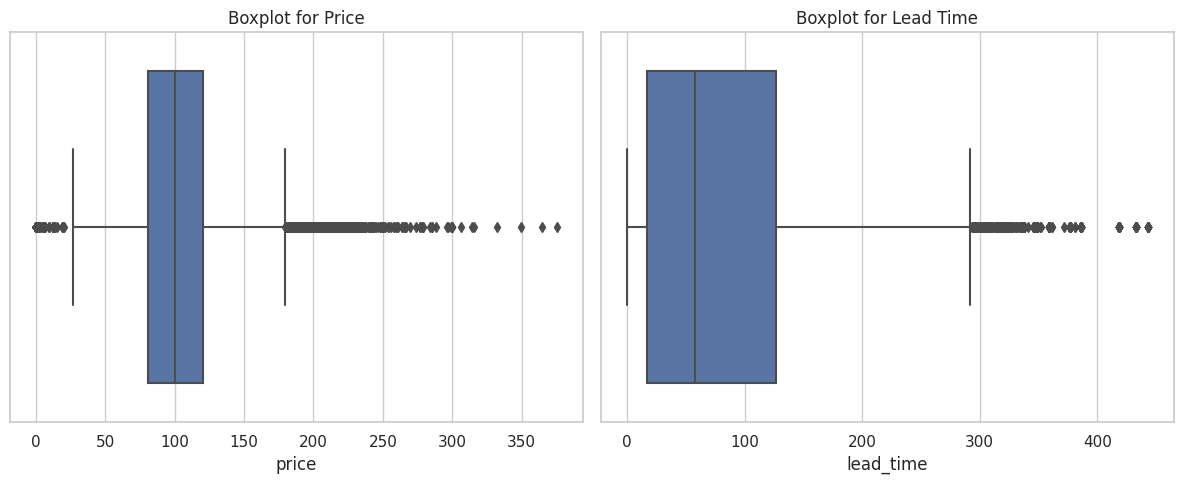

In [8]:
print("\n--- Outlier Analysis ---")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=train_df_fe['price'])
plt.title('Boxplot for Price')

plt.subplot(1, 2, 2)
sns.boxplot(x=train_df_fe['lead_time'])
plt.title('Boxplot for Lead Time')

plt.tight_layout()
plt.show()

# Rubric 6: Present at least three visualizations and provide insights


--- Visualizations ---


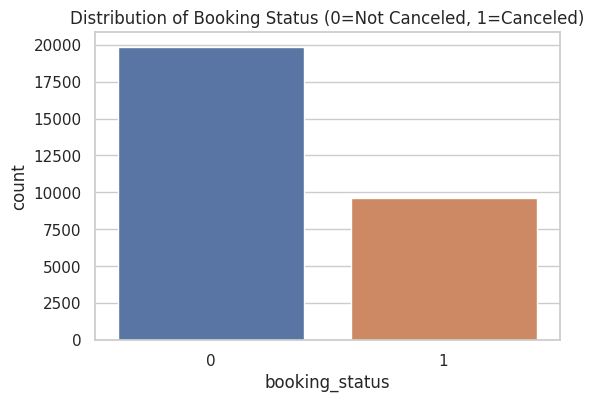

Insight 1: The dataset is imbalanced. 'Not Canceled' (0) bookings are more frequent than 'Canceled' (1) bookings. This means accuracy alone is not a good metric; we should also focus on F1-score or AUC-ROC.


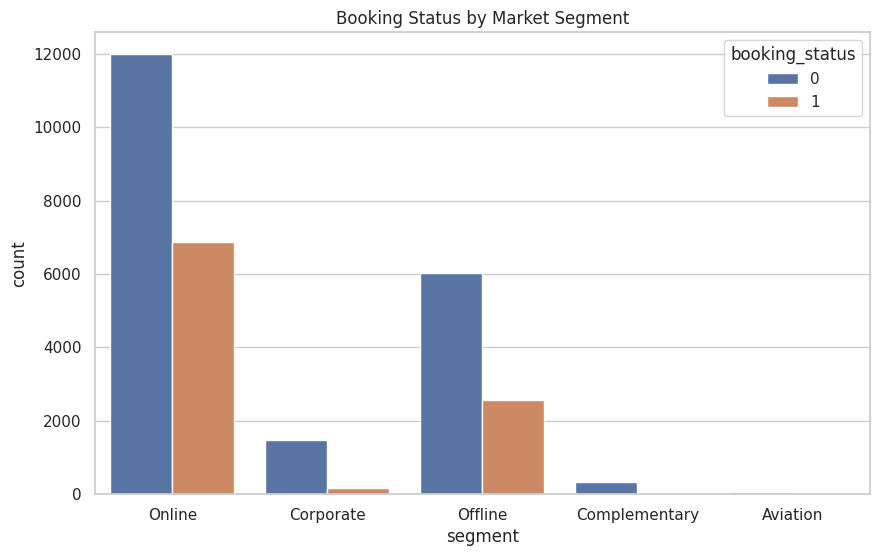

Insight 2: The 'Online TA' (Travel Agent) segment has a significantly higher volume of both bookings and cancellations compared to other segments. The 'Corporate' segment has a very low cancellation rate.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


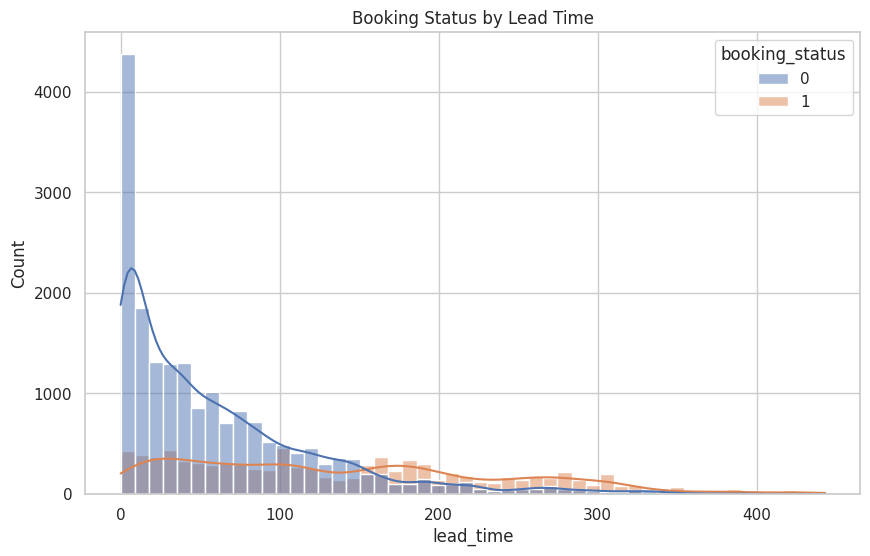

Insight 3: Bookings with a very short lead time (e.g., < 20 days) are highly likely to be 'Not Canceled' (0). As lead time increases, the proportion of 'Canceled' (1) bookings rises significantly. This is a very strong predictive feature.


In [9]:
print("\n--- Visualizations ---")

# Visualization 1: Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='booking_status', data=train_df_fe)
plt.title('Distribution of Booking Status (0=Not Canceled, 1=Canceled)')
plt.show()
print("Insight 1: The dataset is imbalanced. 'Not Canceled' (0) bookings are more frequent than 'Canceled' (1) bookings. This means accuracy alone is not a good metric; we should also focus on F1-score or AUC-ROC.")

# Visualization 2: Cancellation Rate by Market Segment
plt.figure(figsize=(10, 6))
sns.countplot(x='segment', hue='booking_status', data=train_df_fe)
plt.title('Booking Status by Market Segment')
plt.show()
print("Insight 2: The 'Online TA' (Travel Agent) segment has a significantly higher volume of both bookings and cancellations compared to other segments. The 'Corporate' segment has a very low cancellation rate.")

# Visualization 3: Lead Time vs. Cancellation
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df_fe, x='lead_time', hue='booking_status', kde=True, bins=50)
plt.title('Booking Status by Lead Time')
plt.show()
print("Insight 3: Bookings with a very short lead time (e.g., < 20 days) are highly likely to be 'Not Canceled' (0). As lead time increases, the proportion of 'Canceled' (1) bookings rises significantly. This is a very strong predictive feature.")

# Rubric 7: Scale Numerical features and Encode Categorical features

In [10]:
# 1. Define features (X) and target (y)
target = 'booking_status'
features = [col for col in train_df_fe.columns if col not in [target, 'id']]
X = train_df_fe[features]
y = train_df_fe[target]
X_test = test_df_fe[features] # Test data for final submission

# 2. Identify column types
numerical_cols = [
    'adults', 'children', 'weekends', 'weekdays', 
    'lead_time', 'price', 'requests', 'arrival_month', 
    'arrival_day_of_week', 'arrival_day_of_year', 'total_stay', 
    'total_guests', 'price_per_person'
]
categorical_cols = [
    'meal_type', 'room_type', 'segment', 'repeat'
]

# 3. Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 4. Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# 5. Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nPreprocessor created and data split.")


Preprocessor created and data split.


# Rubric 8: Model Building (7 Models)

In [11]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "k-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1)
}

model_performance = {}

print("\n--- Training 8 Baseline Models ---")

for name, model in models.items():
    # Create the full pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_valid)
    
    # Evaluate
    score = f1_score(y_valid, y_pred, average='weighted')
    model_performance[name] = score
    print(f"{name}: Weighted F1-Score = {score:.4f}")


--- Training 8 Baseline Models ---
Logistic Regression: Weighted F1-Score = 0.7807
Decision Tree: Weighted F1-Score = 0.8418
Random Forest: Weighted F1-Score = 0.8807
Gradient Boosting: Weighted F1-Score = 0.8369
AdaBoost: Weighted F1-Score = 0.8001
k-Nearest Neighbors: Weighted F1-Score = 0.8282
XGBoost: Weighted F1-Score = 0.8718
[LightGBM] [Info] Number of positive: 7715, number of negative: 15885
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 23600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.326907 -> initscore=-0.722209
[LightGBM] [Info] Start training from score -0.722209
LightGBM: Weighted F1-Score = 0.8694


# Rubric 9: Hyperparameter Tuning on any 3 of the models

In [12]:
# We will tune: RandomForest, XGBoost, and LightGBM
# Note: Use small 'n_iter' for speed, increase for better results

# 1. RandomForest
rf_pipeline = Pipeline([('preprocessor', preprocessor),
                        ('model', RandomForestClassifier(random_state=42, n_jobs=-1))])

rf_params = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_leaf': [1, 2, 4],
    'model__min_samples_split': [2, 5, 10]
}

rf_search = RandomizedSearchCV(rf_pipeline, rf_params, n_iter=10, cv=3, 
                               scoring='f1_weighted', random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)
print(f"Best RandomForest Score: {rf_search.best_score_:.4f}")
print(f"Best RandomForest Params: {rf_search.best_params_}")


# 2. XGBoost
xgb_pipeline = Pipeline([('preprocessor', preprocessor),
                         ('model', XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'))])

xgb_params = {
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.7, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(xgb_pipeline, xgb_params, n_iter=10, cv=3, 
                                scoring='f1_weighted', random_state=42, n_jobs=-1)
xgb_search.fit(X_train, y_train)
print(f"\nBest XGBoost Score: {xgb_search.best_score_:.4f}")
print(f"Best XGBoost Params: {xgb_search.best_params_}")


# 3. LightGBM
lgbm_pipeline = Pipeline([('preprocessor', preprocessor),
                          ('model', LGBMClassifier(random_state=42, n_jobs=-1))])

lgbm_params = {
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__num_leaves': [20, 31, 40],
    'model__subsample': [0.7, 0.8, 1.0]
}

lgbm_search = RandomizedSearchCV(lgbm_pipeline, lgbm_params, n_iter=10, cv=3, 
                                 scoring='f1_weighted', random_state=42, n_jobs=-1)
lgbm_search.fit(X_train, y_train)
print(f"\nBest LightGBM Score: {lgbm_search.best_score_:.4f}")
print(f"Best LightGBM Params: {lgbm_search.best_params_}")

Best RandomForest Score: 0.8785
Best RandomForest Params: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': None}

Best XGBoost Score: 0.8720
Best XGBoost Params: {'model__subsample': 0.8, 'model__n_estimators': 500, 'model__max_depth': 5, 'model__learning_rate': 0.2}
[LightGBM] [Info] Number of positive: 7715, number of negative: 15885
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 23600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.326907 -> initscore=-0.722209
[LightGBM] [Info] Start training from score -0.722209

Best LightGBM Score: 0.8778
Best LightGBM Params: {'model__subsample': 0.8, 'model__num_leaves': 40, 'model__n_es

# Rubric 10: Comparison of model performances


--- Model Performance Comparison ---
                     F1_Score
Random Forest        0.880668
XGBoost              0.871850
LightGBM             0.869362
Decision Tree        0.841796
Gradient Boosting    0.836926
k-Nearest Neighbors  0.828229
AdaBoost             0.800064
Logistic Regression  0.780729


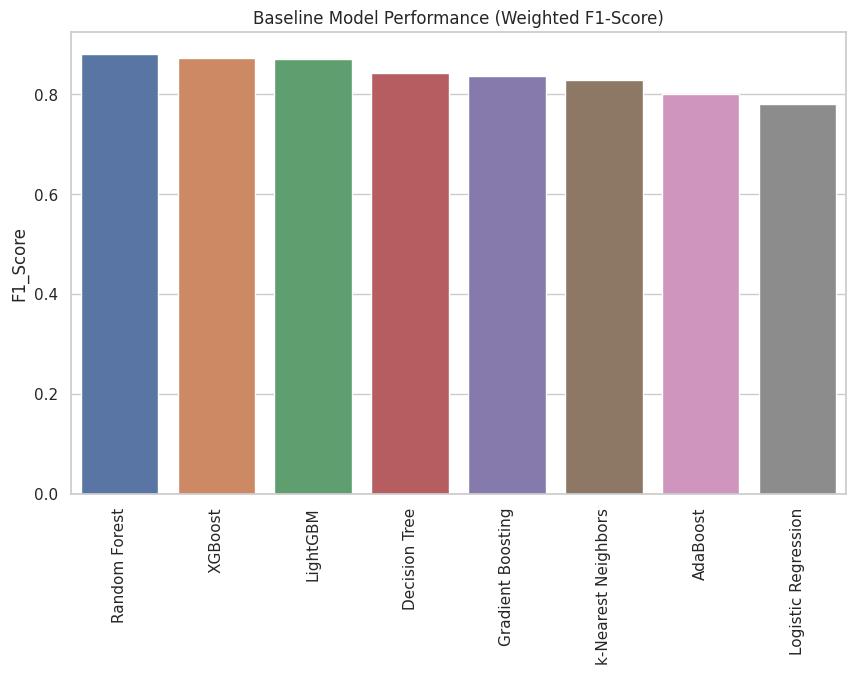

In [13]:
# Create a DataFrame for comparison
performance_df = pd.DataFrame.from_dict(
    model_performance, orient='index', columns=['F1_Score']
).sort_values(by='F1_Score', ascending=False)

print("\n--- Model Performance Comparison ---")
print(performance_df)

# Plot the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=performance_df.index, y=performance_df['F1_Score'])
plt.title('Baseline Model Performance (Weighted F1-Score)')
plt.xticks(rotation=90)
plt.show()

In [14]:
# Select the best model (e.g., rf_search, xgb_search, or lgbm_search)
best_model_pipeline = xgb_search.best_estimator_
# or use your original model if it scored higher
# best_model_pipeline = rf_search.best_estimator_ 

# Evaluate on the validation set one last time
y_valid_pred = best_model_pipeline.predict(X_valid)
print("\n--- Final Model Evaluation (on Validation Set) ---")
print(f"Final Accuracy: {accuracy_score(y_valid, y_valid_pred):.4f}")
print(f"Final Weighted F1-Score: {f1_score(y_valid, y_valid_pred, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_valid, y_valid_pred))


# --- Create Submission File ---
print("\nCreating submission file...")
# We already trained our best_model_pipeline on the (X_train, y_train) split.
# For a final submission, it's best to retrain on ALL training data (X, y)
# Note: Retraining can take time
# best_model_pipeline.fit(X, y) 

# Make predictions on the actual test set
test_predictions = best_model_pipeline.predict(X_test)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'booking_status': test_predictions
})

# Save to CSV
submission_df.to_csv('submission.csv', index=False)

print("submission.csv created successfully!")
print(submission_df.head())


--- Final Model Evaluation (on Validation Set) ---
Final Accuracy: 0.8776
Final Weighted F1-Score: 0.8762

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3985
           1       0.84      0.77      0.80      1915

    accuracy                           0.88      5900
   macro avg       0.87      0.85      0.86      5900
weighted avg       0.88      0.88      0.88      5900


Creating submission file...
submission.csv created successfully!
   id  booking_status
0   0               0
1   1               0
2   2               0
3   3               1
4   4               0
